In [ ]:
# for Google Colab
# !git clone https://github.com/pavelshapka/Q_func_AM.git
# !pip3 install -r /content/Q_func_AM/requirements.txt
# import os
# os.chdir("/content/Q_func_AM")

In [1]:
# for virtual machine
!pip3 install -r requirements.txt


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.95' 

import tensorflow as tf
tf.config.experimental.set_visible_devices([], "GPU")

from classification.default_loader import get_base_dataloaders, CIFAR10_MEANS, CIFAR10_STD
from sas_stack.sars_dataloader import get_sars_dataloaders
from sa_stack import get_sar_dataloaders, TrainerModule, RegressionSAInceptionNetV1

import jax
import matplotlib.pyplot as plt
from flax import linen as nn

import numpy as np

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

2025-04-24 16:56:03.822295: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745513763.843785    5909 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745513763.851039    5909 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745513763.868232    5909 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745513763.868250    5909 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745513763.868252    5909 computation_placer.cc:177] computation placer alr

In [2]:
jax.devices()

[CudaDevice(id=0)]

In [3]:
bs = 512

train_loader, val_loader = get_sar_dataloaders(batch_size=bs,
                                               reward=10,
                                               gamma=0.9,
                                               min_num_steps=5,
                                               max_num_steps=23)

In [4]:
train_iter = iter(train_loader)
images, rewards = next(train_iter)

val_iter = iter(val_loader)
val_images, val_rewards = next(val_iter)

2025-04-24 16:56:21.100702: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


In [5]:
states = val_images[..., :3]
actions = val_images[..., 3:6]
# states_hat = val_images[..., 6:9]

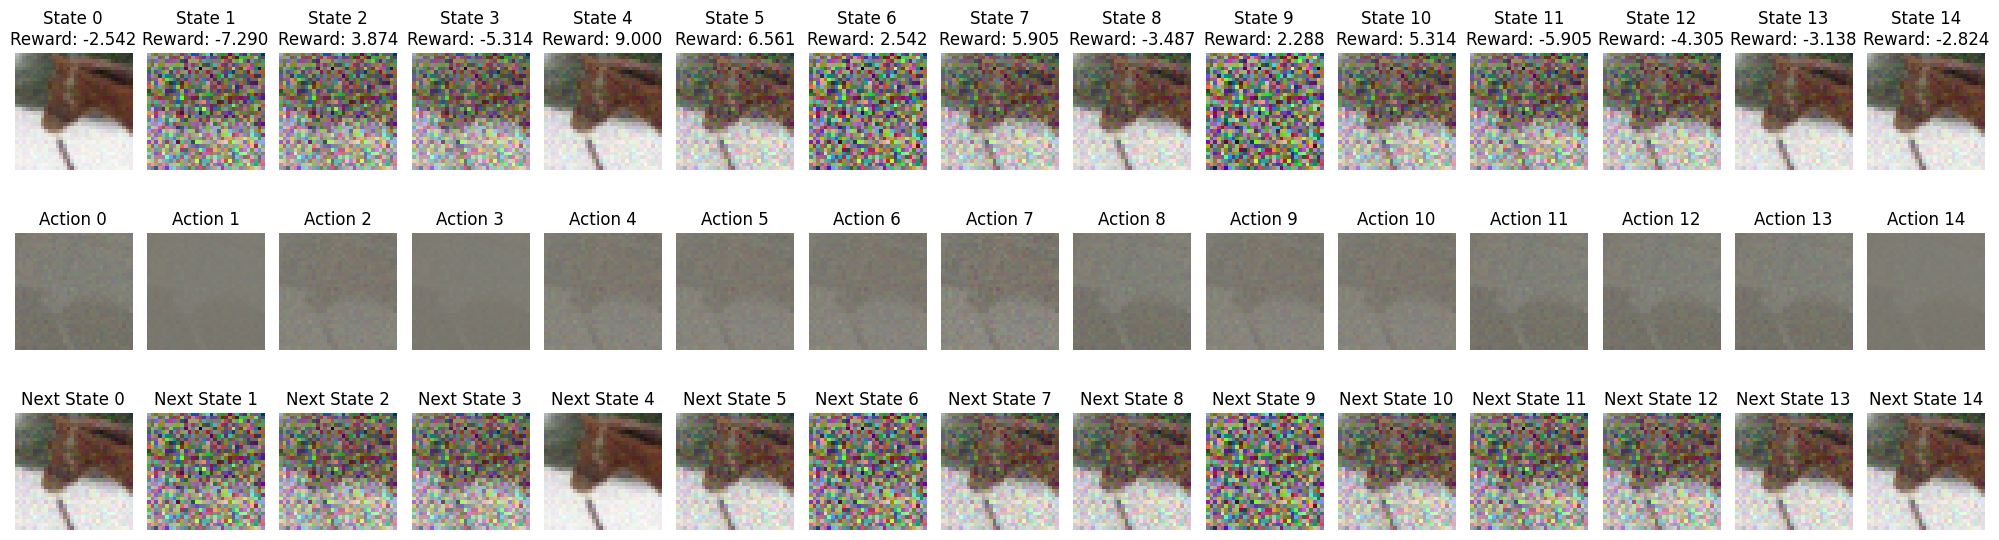

In [6]:
def plot_trajectory(s, a, num_steps=15):
    plt.figure(figsize=(20, 6))

    for i in range(num_steps):
        # State
        plt.subplot(3, num_steps, i+1)
        plt.imshow((s[i].numpy() * CIFAR10_STD + CIFAR10_MEANS))  # Денормализация
        plt.title(f"State {i}\nReward: {val_rewards[i][0]:.3f}")
        plt.axis('off')

        # Action (визуализируем как разницу)
        plt.subplot(3, num_steps, num_steps+i+1)
        plt.imshow((a[i].numpy() * CIFAR10_STD + CIFAR10_MEANS))
        plt.title(f"Action {i}")
        plt.axis('off')

        # Next State
        plt.subplot(3, num_steps, 2*num_steps+i+1)
        plt.imshow(((s[i].numpy() + a[i].numpy()) * CIFAR10_STD + CIFAR10_MEANS))
        plt.title(f"Next State {i}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Визуализируем первую траекторию в батче
plot_trajectory(states, actions)

In [7]:
def train_sa_regressor(*args, num_epochs=200, start_from=0, train=True, **kwargs):
    # Create a trainer module with specified hyperparameters
    trainer = TrainerModule(*args, **kwargs)
    if trainer.checkpoint_exists():
        start_from = trainer.load_model()

    if train:
        print(f"current_epoch = {start_from}")
        trainer.train_model(train_loader,
                            val_loader,
                            rng=jax.random.PRNGKey(42),
                            num_epochs=num_epochs,
                            start_from=start_from)
    # Test trained model
    val_loss = trainer.eval_model(val_loader)
    return trainer, {'val': val_loss}

In [8]:
googlenet_trainer, googlenet_results = train_sa_regressor(model_class=RegressionSAInceptionNetV1,
                                                        model_name="RegressionSAInceptionNetV1",
                                                        model_hparams={"activation": nn.relu},
                                                        batch_size=bs,
                                                        optimizer_name="adamw",
                                                        optimizer_hparams={"lr": 1e-4,
                                                                           "weight_decay": 1e-5},
                                                        exmp_imgs=jax.device_put(next(iter(train_loader))[0]._numpy()),
                                                        num_epochs=500,
                                                        train=True)

2025-04-24 16:56:35.754219: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


None
current_epoch = 0


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: shapka-pa (shapka-pa-moscow-institute-of-physics-and-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


  0%|          | 0/10 [00:00<?, ?it/s]

Traced<ShapedArray(uint32[2])>with<DynamicJaxprTrace>
Traced<ShapedArray(uint32[2])>with<DynamicJaxprTrace>


2025-04-24 17:07:37.202039: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


None
None


2025-04-24 17:08:09.375863: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
 10%|█         | 1/10 [10:39<1:35:58, 639.80s/it]

Traced<ShapedArray(uint32[2])>with<DynamicJaxprTrace>


 20%|██        | 2/10 [19:42<1:17:43, 582.97s/it]

Traced<ShapedArray(uint32[2])>with<DynamicJaxprTrace>


2025-04-24 17:26:19.487957: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
 30%|███       | 3/10 [28:49<1:06:03, 566.21s/it]

Traced<ShapedArray(uint32[2])>with<DynamicJaxprTrace>


 40%|████      | 4/10 [38:12<56:29, 564.85s/it]  

Traced<ShapedArray(uint32[2])>with<DynamicJaxprTrace>


 50%|█████     | 5/10 [47:10<46:16, 555.39s/it]

Traced<ShapedArray(uint32[2])>with<DynamicJaxprTrace>
None


2025-04-24 17:54:29.330669: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
 60%|██████    | 6/10 [58:21<38:54, 583.58s/it]


KeyboardInterrupt: 

## Проверим, что модель корректна через обучение классификации на CIFAR-10

In [ ]:
train_loader, val_loader, test_loader = get_base_dataloaders(batch_size=16)

In [ ]:
train_iter = iter(train_loader)
images, _ = next(train_iter)

In [ ]:
NUM_IMAGES = 10

nrows, ncols = 2, 5
fig, axs = plt.subplots(figsize=(20, 10), nrows=nrows, ncols=ncols)

for i in range(NUM_IMAGES):
    img = (images[i]._numpy() * CIFAR10_STD + CIFAR10_MEANS)
    axs[i//ncols, i%ncols].imshow(img)
    axs[i//ncols, i%ncols].axis("off")

plt.show()
plt.close()

In [ ]:
def train_classifier(*args, num_epochs=200, start_from=0, train=True, **kwargs):
    # Create a trainer module with specified hyperparameters
    trainer = TrainerModule(*args, **kwargs)
    if trainer.checkpoint_exists():
        start_from = trainer.load_model()

    if train:
        print(f"current_epoch = {start_from}")
        trainer.train_model(train_loader,
                            val_loader,
                            rng=jax.random.PRNGKey(42),
                            num_epochs=num_epochs,
                            start_from=start_from)
    # Test trained model
    val_acc = trainer.eval_model(val_loader)
    test_acc = trainer.eval_model(test_loader)
    return trainer, {'val': val_acc, 'test': test_acc}

In [ ]:
googlenet_trainer, googlenet_results = train_classifier(model_class=InceptionNetV1,
                                                        model_name="InceptionNetV1",
                                                        model_hparams={"num_classes": 10,
                                                                       "activation": nn.relu},
                                                        optimizer_name="adamw",
                                                        optimizer_hparams={"lr": 3e-4,
                                                                           "weight_decay": 1e-5},
                                                        exmp_imgs=jax.device_put(next(iter(train_loader))[0]._numpy()),
                                                        num_epochs=10,
                                                        train=True)

In [ ]:
googlenet_results